In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
env = parse_contacts(mechanism, urdf, .5);
x0 = MechanismState(mechanism)
Δt = 0.01;

In [8]:
q0 = [1., 0., 0., 0., 0., 0., .025]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 10

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=false);
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=true);

Explicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Implicit Contacts


LoadError: [91mInterruptException:[39m

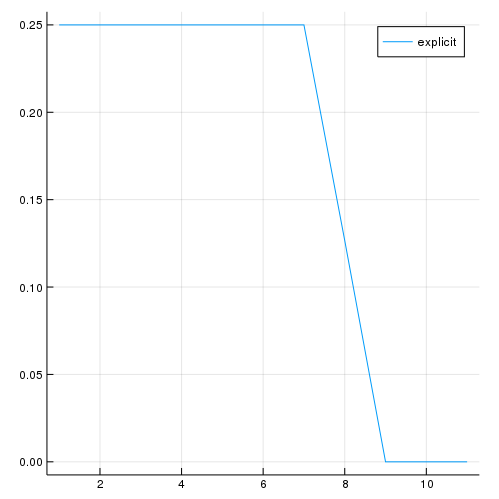

In [4]:
ts = cumsum([Δt for i in 1:N]);
plot(traj_exp[11,:],label="explicit")
# plot!(traj_imp[11,:],label="implicit")

In [7]:
display(traj_exp[1:7,9])
display(traj_exp[8:13,9])
display(traj_exp[14:20,9])
# display(traj_exp[1:7,7])
# display(traj_exp[8:13,7])

7-element Array{Float64,1}:
  1.0        
  8.18e-12   
  8.18e-12   
  8.18e-12   
  0.016266   
  8.52931e-12
 -4.08867e-9 

6-element Array{Float64,1}:
  8.0e-12    
  8.0e-12    
  8.0e-12    
  9.05748e-9 
  1.42951e-18
 -1.07683e-7 

7-element Array{Float64,1}:
 0.0       
 0.302637  
 0.214285  
 1.59316   
 0.214285  
 8.04123e-9
 5.48421   

In [11]:
# display(traj_imp[1:7,8])
# display(traj_imp[8:13,8])
display(traj_imp[1:7,10])
display(traj_imp[8:13,10])

7-element Array{Float64,1}:
  1.0        
  9.225e-12  
  9.15742e-12
  9.225e-12  
  0.0419433  
  5.5368e-12 
 -4.23291e-8 

6-element Array{Float64,1}:
  9.0e-12    
  9.00004e-12
  9.0e-12    
  0.692523   
 -9.97684e-11
 -0.876708   

In [13]:
display(traj_exp[14,10])

0.0

In [ ]:
display(traj_exp[8:13,5:9])
display(traj_imp[8:13,5:9])

In [ ]:
println(traj_exp[7+6+1:end,9])
# println(traj_imp[7+6+1:end,9])

In [ ]:
display("explicit")
display(traj_exp[14:end,9])
display("implicit")
display(traj_imp[14:end,9])

In [ ]:
println(traj_imp[14:end,9])

In [ ]:
DrakeVisualizer.any_open_windows() || (DrakeVisualizer.new_window(); sleep(1));
geometries = visual_elements(mechanism, URDFVisuals(urdf))
vis = Visualizer(mechanism, geometries);

In [ ]:
traj = traj_exp
qs = [traj[1:num_positions(x0),i] for i in 1:N]
ts = cumsum([Δt for i in 1:N]);
RigidBodyTreeInspector.animate(vis, mechanism, ts, qs; realtimerate = .25);